## Figure: Learning efficiency

## Set up

In [1]:
# autoreload
%load_ext autoreload
%autoreload 2
# jupyter black formatter
%load_ext jupyter_black

import subprocess
import os
import sys

gitroot_path = subprocess.check_output(
    ["git", "rev-parse", "--show-toplevel"], universal_newlines=True
)

os.chdir(os.path.join(gitroot_path[:-1], "pirnns"))
print("Working directory: ", os.getcwd())

sys_dir = os.path.dirname(os.getcwd())
sys.path.append(sys_dir)
print("Directory added to path: ", sys_dir)
sys.path.append(os.getcwd())
print("Directory added to path: ", os.getcwd())

Working directory:  /home/facosta/pirnns/pirnns
Directory added to path:  /home/facosta/pirnns
Directory added to path:  /home/facosta/pirnns/pirnns


## Load all the trained models

In [18]:
from pirnns.notebooks.utils import load_experiment_sweep


sweep_dir = (
    "/home/facosta/pirnns/pirnns/logs/experiments/timescales_sweep_20250919_130449"
)

device = "cuda" if torch.cuda.is_available() else "cpu"

models, metadata, summary = load_experiment_sweep(
    sweep_dir=sweep_dir,
    device=device,
    use_lightning_checkpoint=True,
    checkpoint_type="best",
)

print("\nLoaded experiments:")
for exp_name, seeds in models.items():
    print(f"  {exp_name}: {len(seeds)} seeds")

    # Show timescales config for this experiment
    sample_config = list(seeds.values())[0]["config"]
    timescales_config = sample_config["timescales_config"]
    print(f"    Timescales config: {timescales_config}")

    # Show validation loss stats
    val_losses = [seed_data["final_val_loss"] for seed_data in seeds.values()]
    print(f"    Val loss range: {min(val_losses):.4f} - {max(val_losses):.4f}")

    # Show training data availability
    training_data_count = sum(
        1 for seed_data in seeds.values() if seed_data["training_losses"]
    )
    print(f"    Training curves available: {training_data_count}/{len(seeds)} seeds")
    print()

Loading 8 experiments with 5 seeds each...
Total models to load: 40
Using Lightning checkpoints

Loading experiment: discrete_single_025
  ✓ Loaded discrete_single_025/seed_0
  ✓ Loaded discrete_single_025/seed_1
  ✓ Loaded discrete_single_025/seed_2
  ✓ Loaded discrete_single_025/seed_3
  ✓ Loaded discrete_single_025/seed_4
Loading experiment: discrete_single_05
  ✓ Loaded discrete_single_05/seed_0
  ✓ Loaded discrete_single_05/seed_1
  ✓ Loaded discrete_single_05/seed_2
  ✓ Loaded discrete_single_05/seed_3
  ✓ Loaded discrete_single_05/seed_4
Loading experiment: discrete_single_075
  ✓ Loaded discrete_single_075/seed_0
  ✓ Loaded discrete_single_075/seed_1
  ✓ Loaded discrete_single_075/seed_2
  ✓ Loaded discrete_single_075/seed_3
  ✓ Loaded discrete_single_075/seed_4
Loading experiment: discrete_single_1
  ✓ Loaded discrete_single_1/seed_0
  ✓ Loaded discrete_single_1/seed_1
  ✓ Loaded discrete_single_1/seed_2
  ✓ Loaded discrete_single_1/seed_3
  ✓ Loaded discrete_single_1/seed_4
L

discrete_single_025: 5 seeds, final train loss = 6.0942 ± 0.0028
discrete_single_05: 5 seeds, final train loss = 6.0655 ± 0.0029
discrete_single_075: 5 seeds, final train loss = 6.0550 ± 0.0030
discrete_single_1: 5 seeds, final train loss = 6.0518 ± 0.0035
discrete_two: 5 seeds, final train loss = 6.0582 ± 0.0030
discrete_four: 5 seeds, final train loss = 6.0540 ± 0.0031
continuous_powerlaw_20: 5 seeds, final train loss = 6.0551 ± 0.0031
continuous_powerlaw_15: 5 seeds, final train loss = 6.0568 ± 0.0030


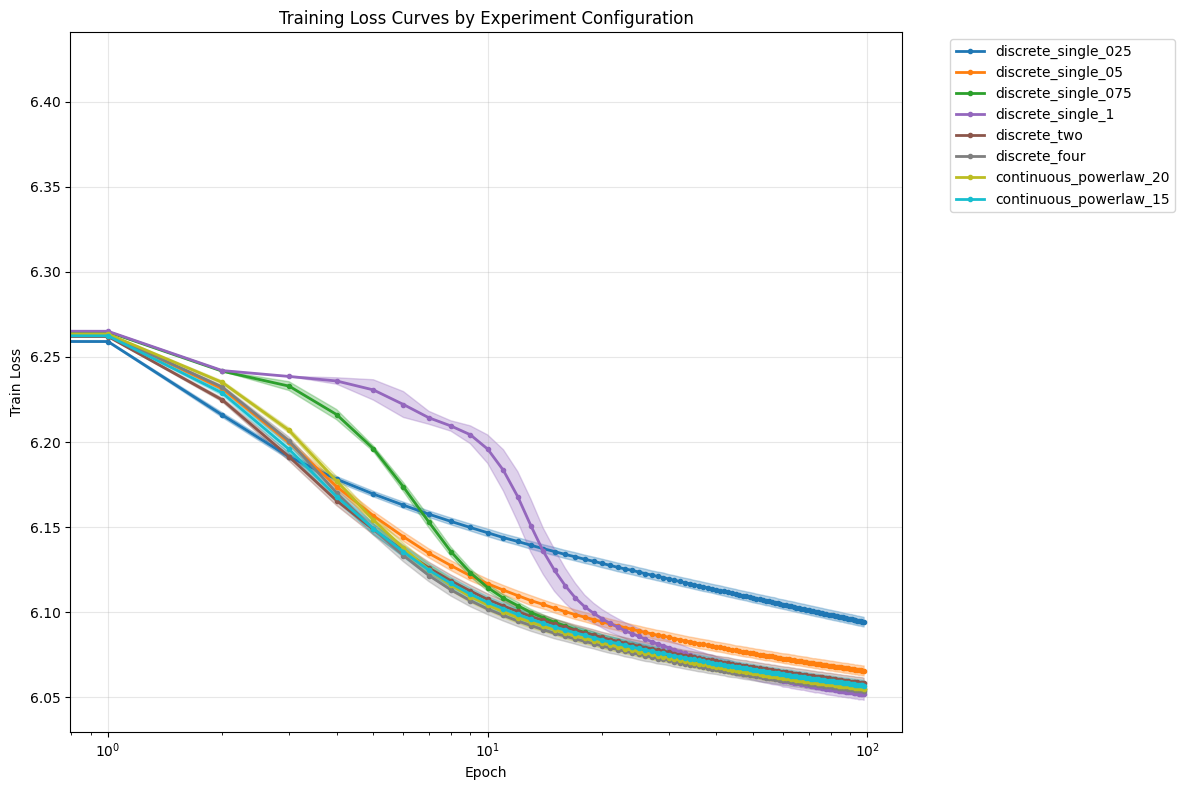

discrete_single_025: 5 seeds, final val loss = 6.0944 ± 0.0026
discrete_single_05: 5 seeds, final val loss = 6.0655 ± 0.0025
discrete_single_075: 5 seeds, final val loss = 6.0554 ± 0.0029
discrete_single_1: 5 seeds, final val loss = 6.0518 ± 0.0031
discrete_two: 5 seeds, final val loss = 6.0585 ± 0.0030
discrete_four: 5 seeds, final val loss = 6.0542 ± 0.0030
continuous_powerlaw_20: 5 seeds, final val loss = 6.0551 ± 0.0028
continuous_powerlaw_15: 5 seeds, final val loss = 6.0570 ± 0.0029


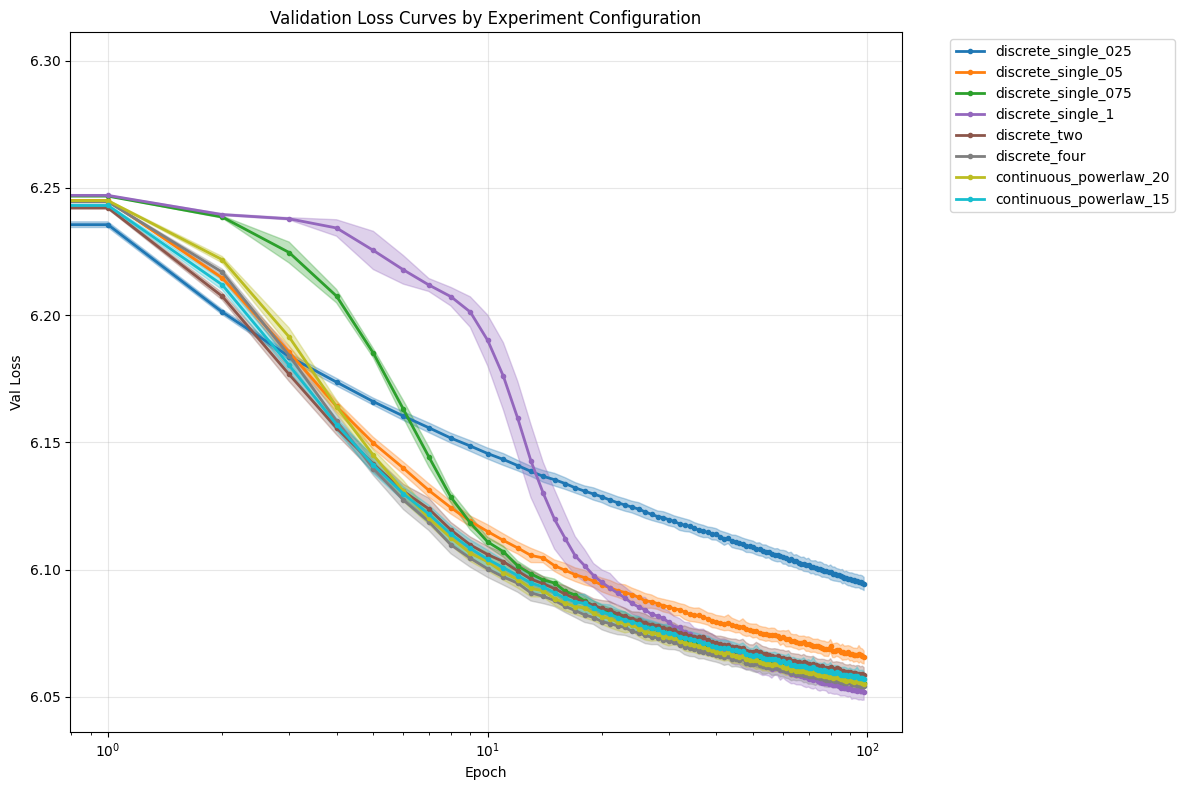

In [29]:
import matplotlib.pyplot as plt
import numpy as np
from typing import Dict, Any


def plot_loss_curves_by_experiment(
    models: Dict[str, Dict[int, Dict[str, Any]]],
    loss_type: str = "train",  # "train" or "val"
    figsize: tuple = (12, 8),
    title: str = None,
    log_x: bool = True,
    log_y: bool = True,
    alpha_fill: float = 0.3,
) -> None:
    """
    Plot mean training/validation loss curves across seeds for each experiment.

    Args:
        models: Dictionary from load_experiment_sweep
        loss_type: "train" or "val"
        figsize: Figure size
        title: Plot title (auto-generated if None)
        log_x: Use log scale on x-axis
        log_y: Use log scale on y-axis
        alpha_fill: Transparency for error bars
    """

    plt.figure(figsize=figsize)

    # Color palette for experiments
    colors = plt.cm.tab10(np.linspace(0, 1, len(models)))

    for exp_idx, (exp_name, seeds) in enumerate(models.items()):
        # Collect loss curves from all seeds
        all_losses = []
        all_epochs = []

        for seed, seed_data in seeds.items():
            training_losses = seed_data["training_losses"]
            if not training_losses:  # Skip if no training data
                continue

            epochs = np.array(training_losses["epochs"])
            if loss_type == "train":
                losses = np.array(training_losses["train_losses"])
            else:  # val
                losses = np.array(training_losses["val_losses"])

            all_losses.append(losses)
            all_epochs.append(epochs)

        if not all_losses:
            print(f"Warning: No training data found for experiment {exp_name}")
            continue

        # Find common epoch range (in case different seeds have different lengths)
        min_length = min(len(losses) for losses in all_losses)

        # Truncate all arrays to common length
        all_losses = [losses[:min_length] for losses in all_losses]
        epochs = all_epochs[0][:min_length]  # Use epochs from first seed

        # Convert to numpy array and compute statistics
        losses_array = np.array(all_losses)  # Shape: (n_seeds, n_epochs)

        mean_losses = np.mean(losses_array, axis=0)
        std_losses = np.std(losses_array, axis=0)

        # Plot mean with error bars
        color = colors[exp_idx]
        plt.plot(
            epochs,
            mean_losses,
            "o-",
            color=color,
            label=exp_name,
            linewidth=2,
            markersize=3,
        )
        plt.fill_between(
            epochs,
            mean_losses - std_losses,
            mean_losses + std_losses,
            alpha=alpha_fill,
            color=color,
        )

        print(
            f"{exp_name}: {len(all_losses)} seeds, final {loss_type} loss = {mean_losses[-1]:.4f} ± {std_losses[-1]:.4f}"
        )

    plt.xlabel("Epoch")
    plt.ylabel(f"{loss_type.capitalize()} Loss")

    if title is None:
        title = f"{loss_type.capitalize()} Loss Curves by Experiment (Mean ± Std across seeds)"
    plt.title(title)

    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(True, alpha=0.3)

    # Apply log scales
    if log_y:
        plt.yscale("log")
    if log_x:
        plt.xscale("log")

    plt.grid(True)

    plt.tight_layout()
    plt.show()


# Plot training loss curves
plot_loss_curves_by_experiment(
    models,
    loss_type="train",
    title="Training Loss Curves by Experiment Configuration",
    log_x=True,
    log_y=False,
)

# Plot validation loss curves
plot_loss_curves_by_experiment(
    models,
    loss_type="val",
    title="Validation Loss Curves by Experiment Configuration",
    log_x=True,
    log_y=False,
)